In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


# 1. Load dataset


In [2]:
from torchvision.datasets import CocoDetection
from torchvision import transforms
import torch

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None, remap_classes=True):
        self.dataset = CocoDetection(root=root, annFile=annFile)
        self.transforms = transforms
        self.class_names = [v['name'] for k, v in self.dataset.coco.cats.items() if v['id'] > 0]

        # Mapping COCO id -> new id
        if remap_classes:
            self.id_map = {v['id']: i for i, (k, v) in enumerate(self.dataset.coco.cats.items()) if v['id'] > 0}
        else:
            self.id_map = None

        # Lọc chỉ những ảnh có ít nhất 1 box
        self.valid_idx = []
        for i in range(len(self.dataset)):
            _, anns = self.dataset[i]
            boxes = [ann for ann in anns if ann['category_id'] != 0]
            if len(boxes) > 0:
                self.valid_idx.append(i)

    def __getitem__(self, idx):
        idx = self.valid_idx[idx]  # chỉ lấy ảnh có box
        img, anns = self.dataset[idx]
        boxes = []
        labels = []
        for ann in anns:
            if ann['category_id'] == 0:
                continue
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            if self.id_map is not None:
                labels.append(self.id_map[ann['category_id']])
            else:
                labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.valid_idx)


# ---- 1. Load dataset ----
train = CocoDataset(
    root="/kaggle/input/acne04/COCO_Split/train",
    annFile="/kaggle/input/acne04/COCO_Split/train/instances_train.json",
    transforms=transforms.ToTensor()
)

val = CocoDataset(
    root="/kaggle/input/acne04/COCO_Split/val",
    annFile="/kaggle/input/acne04/COCO_Split/val/instances_val.json",
    transforms=transforms.ToTensor()
)

test = CocoDataset(
    root="/kaggle/input/acne04/COCO_Split/test",
    annFile="/kaggle/input/acne04/COCO_Split/test/instances_test.json",
    transforms=transforms.ToTensor()
)

loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
img, target = train[0]

print("Ảnh:", type(img), img.shape)
print("Target keys:", target.keys())
print("Boxes shape:", target["boxes"].shape)
print("Labels:", target["labels"])
print(target)

Ảnh: <class 'torch.Tensor'> torch.Size([3, 700, 525])
Target keys: dict_keys(['boxes', 'labels'])
Boxes shape: torch.Size([3, 4])
Labels: tensor([2, 2, 2])
{'boxes': tensor([[223., 290., 251., 306.],
        [217., 250., 239., 276.],
        [186., 514., 209., 536.]]), 'labels': tensor([2, 2, 2])}


## Các class

In [4]:
classes = train.dataset.coco.cats
num_classes = len(train.dataset.coco.cats)
print(classes)
print("Số class:", num_classes)

{1: {'id': 1, 'name': 'acne-types'}, 2: {'id': 2, 'name': 'comedones'}, 3: {'id': 3, 'name': 'nodules'}, 4: {'id': 4, 'name': 'papules'}}
Số class: 4


# 2. Visualize data

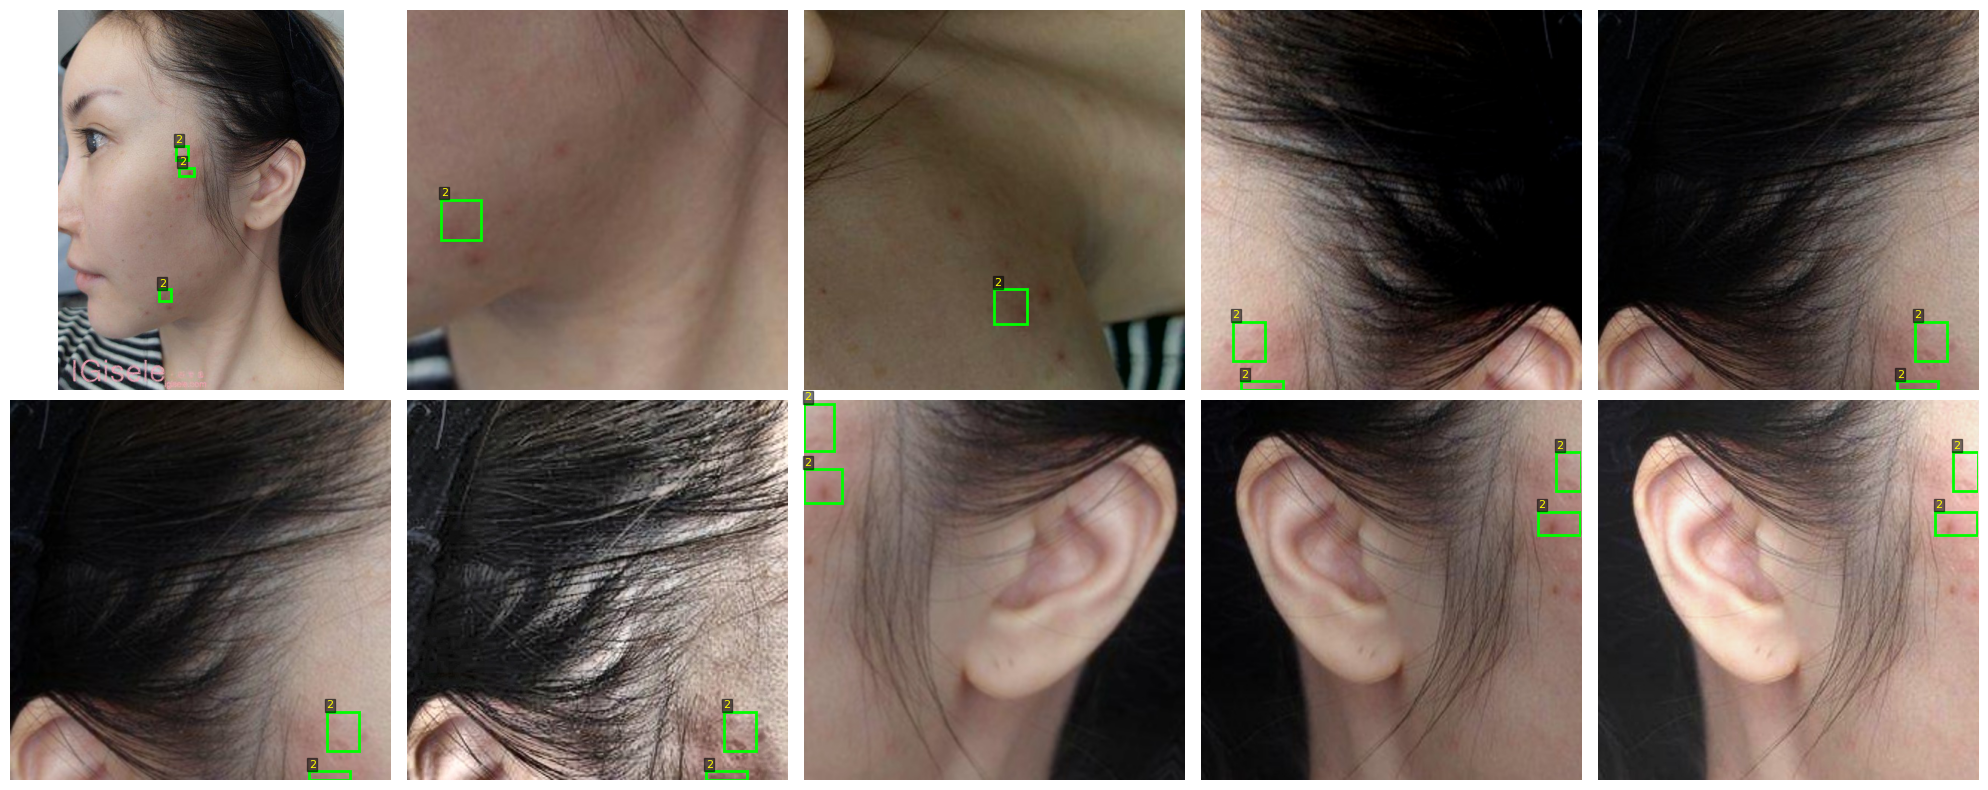

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ---- 2. Số lượng ảnh muốn hiển thị ----
num_images = 10
cols = 5
rows = (num_images + cols - 1) // cols

# ---- 3. Tạo figure ----
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

# ---- 4. Lặp qua các ảnh ----
for i in range(num_images):
    img, target = train[i]
    img = img.permute(1, 2, 0).numpy()

    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')

    # Vẽ bounding boxes
    boxes = target['boxes']
    labels = target['labels']
    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)

        # Nếu muốn hiển thị nhãn class id
        ax.text(
            x1, y1 - 5, str(labels[j].item()), color='yellow', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.5, pad=1)
        )

# Ẩn các ô trống nếu num_images không chia hết cho cols
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# 3. Tạo model

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 1. Load DenseNet backbone
densenet = torchvision.models.densenet121(weights="DEFAULT")
backbone = densenet.features # bỏ phần classifier

# 2. Output channels = số channels cuối cùng của feature map
# Với DenseNet121, output là 1024
backbone.out_channels = 1024

# 3. Tạo anchor generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# 4. ROI Pooling
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# 5. Tạo model Faster R-CNN
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 166MB/s]


In [7]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), 

# 4. DataLoader

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train, batch_size=3, shuffle=True, collate_fn=collate_fn
)

val_loader = DataLoader(
    val, batch_size=3, shuffle=False, collate_fn=collate_fn
)

test_loader = DataLoader(
    test, batch_size=3, shuffle=False, collate_fn=collate_fn
)

# 5. Optimizer

In [9]:
import torch

# Chỉ huấn luyện weights của head (không fine-tune DenseNet hoàn toàn)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 6. Training loop

In [10]:
!wandb login bdb6b35469181589a4f8b18159a4f3c1b7770eb8

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [11]:
import wandb
wandb.init(
    project="Densenet-detection",
    config={
        "epochs": 5,
        "batch_size": 3,
        "optimizer": "SGD",
        "lr": 0.005,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "backbone": "DenseNet121",
        "model": "FasterRCNN"
    }
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [12]:
# ---- 3️⃣ Hàm tính confusion matrix ----
def compute_confusion_matrix(preds, targets, num_classes, iou_thresh=0.5):
    y_true, y_pred = [], []
    for pred, target in zip(preds, targets):
        boxes_pred = pred["boxes"]
        labels_pred = pred["labels"]
        boxes_true = target["boxes"]
        labels_true = target["labels"]

        for i, bp in enumerate(boxes_pred):
            ious = box_iou(bp.unsqueeze(0), boxes_true)
            max_iou, idx = ious.max(1)
            if max_iou > iou_thresh:
                y_pred.append(labels_pred[i].item())
                y_true.append(labels_true[idx].item())

    if len(y_true) == 0:
        cm = np.zeros((num_classes, num_classes), dtype=int)
    else:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    print(y_true[:10])
    print(y_pred[:10])
    print(test.class_names)
    return cm, y_true, y_pred

# ---- 4️⃣ Hàm IoU helper ----
def box_iou(box1, box2):
    # box: (x1, y1, x2, y2)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    inter_x1 = torch.max(box1[:, None, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, None, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, None, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, None, 3], box2[:, 3])
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    union = area1[:, None] + area2 - inter_area
    return inter_area / union

In [13]:
import torch
from tqdm import tqdm
import wandb
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

# ---- 5️⃣ Vòng huấn luyện ----
num_epochs = 5
num_classes = num_classes  # thay bằng số lớp thật
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, targets = batch
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # 🧹 Dọn dẹp GPU memory
        del loss, loss_dict, images, targets
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, targets = batch
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Tạm bật train mode để model trả về loss_dict
            model.train()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            val_loss += loss.item()
            model.eval()

    avg_val_loss = val_loss / len(val_loader)

    # ---- 🔹 Log chỉ loss sau mỗi epoch ----
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

# ---- 2️⃣ Sau khi train xong: tính mAP và Confusion Matrix ----
print("\n🚀 Training done! Now computing final mAP and confusion matrix...")

model.eval()
metric = MeanAveragePrecision()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating final performance"):
        images, targets = batch
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)

        all_preds.extend([{k: v.cpu() for k, v in o.items()} for o in outputs])
        all_targets.extend([{k: v.cpu() for k, v in t.items()} for t in targets])

# --- Compute final mAP ---
metric.update(all_preds, all_targets)
results = metric.compute()
map_50 = results["map_50"].item()
map_75 = results["map_75"].item()
map_all = results["map"].item()

# --- Compute confusion matrix ---
cm, y_true, y_pred = compute_confusion_matrix(all_preds, all_targets, num_classes)

# 🔹 Chuẩn hóa kiểu dữ liệu để W&B hiển thị đúng
y_true = [int(y) for y in y_true]
y_pred = [int(y) for y in y_pred]

# 🔹 Đảm bảo class_names khớp với số lớp
class_names = test.class_names
assert len(class_names) == num_classes, f"⚠️ class_names ({len(class_names)}) != num_classes ({num_classes})"

# y_true, y_pred là list các label (sau khi compute_confusion_matrix)
f1_per_class = f1_score(y_true, y_pred, average=None)
f1_dict = {f"F1_{cls_name}": f1 for cls_name, f1 in zip(test.class_names, f1_per_class)}

# Log các scalar mAP & F1
wandb.log({
    "Final mAP": map_all,
    "Final mAP@0.5": map_50,
    "Final mAP@0.75": map_75,
    **f1_dict
})

# Log confusion matrix riêng (plot)
wandb.log({
    "Confusion Matrix": wandb.plot.confusion_matrix(
        preds=y_pred,
        y_true=y_true,
        class_names=test.class_names
    )
})

print(f"\n✅ Final Evaluation: mAP={map_all:.4f} | mAP@0.5={map_50:.4f} | mAP@0.75={map_75:.4f}")
print(f"F1 per class: {f1_dict}")

Epoch 1/5 [Val]: 100%|██████████| 144/144 [00:34<00:00,  4.16it/s]


[Epoch 1/5] Train Loss: 0.6101 | Val Loss: 0.3477


Epoch 2/5 [Val]: 100%|██████████| 144/144 [00:34<00:00,  4.18it/s]


[Epoch 2/5] Train Loss: 0.5941 | Val Loss: 0.3265


Epoch 3/5 [Val]: 100%|██████████| 144/144 [00:34<00:00,  4.16it/s]


[Epoch 3/5] Train Loss: 0.5817 | Val Loss: 0.3348


Epoch 4/5 [Val]: 100%|██████████| 144/144 [00:34<00:00,  4.11it/s]


[Epoch 4/5] Train Loss: 0.5709 | Val Loss: 0.3146


Epoch 5/5 [Val]: 100%|██████████| 144/144 [00:34<00:00,  4.14it/s]


[Epoch 5/5] Train Loss: 0.5600 | Val Loss: 0.3132

🚀 Training done! Now computing final mAP and confusion matrix...


Evaluating final performance: 100%|██████████| 125/125 [00:25<00:00,  4.89it/s]


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 1, 1, 1, 1, 2, 1]
['acne-types', 'comedones', 'nodules', 'papules']

✅ Final Evaluation: mAP=0.0249 | mAP@0.5=0.0744 | mAP@0.75=0.0134
F1 per class: {'F1_acne-types': 0.0, 'F1_comedones': 0.47472527472527476, 'F1_nodules': 0.7024793388429752, 'F1_papules': 0.37267080745341613}


In [22]:
print("Unique y_true:", set(y_true))
print("Unique y_pred:", set(y_pred))
all_labels = list(range(num_classes))

Unique y_true: {0, 1, 2, 3}
Unique y_pred: {1, 2, 3}


In [23]:
wandb.log({
    "Final mAP": map_all,
    "Final mAP@0.5": map_50,
    "Final mAP@0.75": map_75,
    **f1_dict
})

wandb.log({
    "Confusion Matrix": wandb.plot.confusion_matrix(
        preds=y_pred+all_labels,
        y_true=y_true+all_labels,
        class_names=test.class_names
    )
})

In [ ]:
def visualize_gt_pred_filtered(images, targets, outputs, class_names=None,
                               score_thresh=0.5, iou_thresh=0.5, n=4):
    """
    Hiển thị n ảnh theo cặp: 
      - Bên trái: Ground Truth (màu đỏ)
      - Bên phải: Prediction (màu xanh) sau khi lọc theo score threshold và NMS.
    """
    n = min(n, len(images))
    fig, axes = plt.subplots(n, 2, figsize=(10, 5*n))
    
    if n == 1:
        axes = [axes]
    
    for i in range(n):
        img_np = images[i].cpu().permute(1,2,0).numpy()
        
        # --- Ground Truth ---
        ax_left = axes[i][0] if n > 1 else axes[0]
        ax_left.imshow(img_np)
        ax_left.axis('off')
        ax_left.set_title(f"Image {i} - Ground Truth", fontsize=10)
        
        for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
            x1, y1, x2, y2 = box.cpu()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax_left.add_patch(rect)
            # Hiển thị class name
            if class_names is not None:
                cls_name = class_names[label.item()]
                ax_left.text(x1, y1-5, cls_name,
                             color='white', fontsize=8,
                             bbox=dict(facecolor='red', alpha=0.5, pad=1))
        
        # --- Prediction ---
        ax_right = axes[i][1] if n > 1 else axes[1]
        ax_right.imshow(img_np)
        ax_right.axis('off')
        ax_right.set_title(f"Image {i} - Prediction (NMS+Thresh)", fontsize=10)
        
        out = outputs[i]
        if len(out['boxes']) == 0:
            continue
        
        # --- Filter theo score threshold ---
        keep_score = out['scores'] > score_thresh
        boxes = out['boxes'][keep_score]
        scores = out['scores'][keep_score]
        labels = out['labels'][keep_score]
        
        # --- Áp dụng NMS ---
        if len(boxes) > 0:
            keep_nms = nms(boxes, scores, iou_threshold=iou_thresh)
            boxes = boxes[keep_nms]
            scores = scores[keep_nms]
            labels = labels[keep_nms]
        
        # --- Vẽ ---
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box.cpu()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax_right.add_patch(rect)
            if class_names is not None:
                cls_name = class_names[label.item()]
                ax_right.text(x1, y1-5, f"{cls_name} {score:.2f}",
                              color='black', fontsize=8,
                              bbox=dict(facecolor='lime', alpha=0.5, pad=1))
            else:
                ax_right.text(x1, y1-5, f"{label.item()} {score:.2f}",
                              color='black', fontsize=8,
                              bbox=dict(facecolor='lime', alpha=0.5, pad=1))
    
    plt.tight_layout()
    plt.show()
    
all_images, all_targets, all_outputs = [], [], []
for i, batch in enumerate(val_loader):
    imgs, tars = batch
    all_images.extend(imgs)
    all_targets.extend(tars)
    outputs = model([img.to(device) for img in imgs])
    all_outputs.extend(outputs)
    if i>2:
        break

visualize_gt_pred_filtered(
    all_images,
    all_targets,
    all_outputs,
    class_names=test.class_names
)
